The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [2]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps  # installing d2l


  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-owm4v2mp
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-owm4v2mp
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=00af799abb6434adbd93c67be07b3c9098ac12e5160f80286ca6042e45c2d075
  Stored in directory: /tmp/pip-ephem-wheel-cache-4eipepyc/wheels/3e/87/36/53b013ece7da539a59fcc56da2d329d7afb08eef9a9a5ae1d1
Successfully built d2l


# 线性回归的从零开始实现
:label:`sec_linear_scratch`

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，(**我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。
在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。


In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。


In [ ]:
help(torch.normal)

In [10]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    # Reshape y to be a column vector. The -1 infers the number of rows.
    return X, y.reshape((-1, 1))

In [11]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，[**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**]。


In [13]:
print('features:', features[0],'\nlabel:', labels[0])
print('features:', features[1],'\nlabel:', labels[1])

features: tensor([0.6021, 0.7678]) 
label: tensor([2.7925])
features: tensor([ 0.1207, -0.4357]) 
label: tensor([5.9138])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


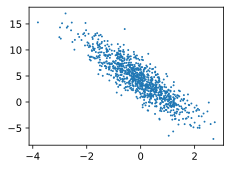

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。


In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。
每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。
GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。
每个批量的特征维度显示批量大小和输入特征数。
同样的，批量的标签形状与`batch_size`相等。


In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3795, -0.0326],
        [ 0.2254, -1.4488],
        [ 0.8878,  0.3786],
        [-1.7119, -0.0165],
        [-0.4415,  0.8112],
        [-1.1672, -0.5947],
        [-1.3254,  0.5403],
        [-0.9989, -0.3065],
        [ 1.4066,  1.4539],
        [ 0.2874, -0.9234]]) 
 tensor([[ 3.5316],
        [ 9.5693],
        [ 4.6935],
        [ 0.8337],
        [ 0.5642],
        [ 3.8843],
        [-0.2768],
        [ 3.2468],
        [ 2.0724],
        [ 7.9044]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

[**在我们开始用小批量随机梯度下降优化我们的模型参数之前**]，
(**我们需要先有一些参数**)。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。


In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[0.0079],
         [0.0028]], requires_grad=True),
 tensor([0.], requires_grad=True))

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用 :numref:`sec_autograd`中引入的自动微分来计算梯度。

## 定义模型

接下来，我们必须[**定义模型，将模型的输入和参数同模型的输出关联起来。**]
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下 :numref:`subsec_broadcasting`中描述的广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。


In [18]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## [**定义损失函数**]

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用 :numref:`sec_linear_regression`中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。


In [19]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## (**定义优化算法**)

正如我们在 :numref:`sec_linear_regression`中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。


In [20]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在 :numref:`chap_optimization`中详细介绍。


In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [22]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034907
epoch 2, loss 0.000126
epoch 3, loss 0.000047


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。
事实上，真实参数和通过训练学到的参数确实非常接近。


In [24]:
w, b

(tensor([[ 1.9990],
         [-3.3992]], requires_grad=True),
 tensor([4.1993], requires_grad=True))

In [23]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0010, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
1. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？


[Discussions](https://discuss.d2l.ai/t/1778)
